# TP 4: Training transformer models for text classification

### Apolline Hadjal

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from umap import UMAP

# load emotion dataset
emotions = load_dataset("emotion")
emotions

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [2]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [3]:
len(train_ds)

16000

In [4]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
train_ds.column_names

['text', 'label']

In [6]:
print(train_ds.features)

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


In [7]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [8]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


## Exercise 1

In [9]:
# Load IMDB dataset as an example
imdb = load_dataset("imdb")
print(imdb)
print(f"Number of classes: {imdb['train'].features['label'].num_classes}")
print(f"Class names: {imdb['train'].features['label'].names}")

# Explore structure
print(imdb["train"][0])

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Number of classes: 2
Class names: ['neg', 'pos']
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the

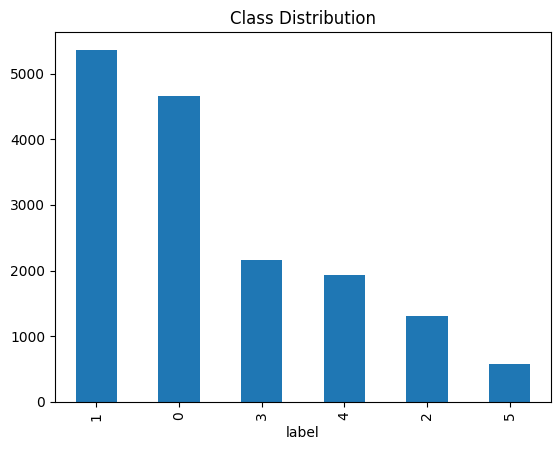

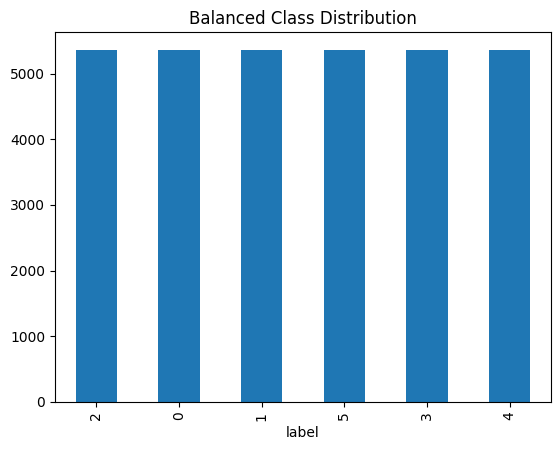

In [10]:
# Check class distribution
emotions.set_format(type="pandas")
df = emotions["train"][:]

# Visualize imbalance
df["label"].value_counts().plot.bar()
plt.title("Class Distribution")
plt.show()

# Strategy 1: Oversample minority classes
from sklearn.utils import resample

def balance_dataset(df):
    # Find the maximum class size
    max_size = df['label'].value_counts().max()

    # List to hold balanced data
    balanced_dfs = []

    # Oversample each class to match the largest class
    for label in df['label'].unique():
        df_class = df[df['label'] == label]
        df_oversampled = resample(df_class,
                                  replace=True,     # sample with replacement
                                  n_samples=max_size,    # match majority class
                                  random_state=42)
        balanced_dfs.append(df_oversampled)

    # Combine and shuffle
    balanced_df = pd.concat(balanced_dfs)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

balanced_df = balance_dataset(df)
balanced_df['label'].value_counts().plot.bar()
plt.title("Balanced Class Distribution")
plt.show()

# Strategy 2: Undersample majority classes
def undersample_dataset(df):
    min_size = df['label'].value_counts().min()

    balanced_dfs = []
    for label in df['label'].unique():
        df_class = df[df['label'] == label]
        df_undersampled = resample(df_class,
                                   replace=False,
                                   n_samples=min_size,
                                   random_state=42)
        balanced_dfs.append(df_undersampled)

    balanced_df = pd.concat(balanced_dfs)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

undersampled_df = undersample_dataset(df)

# Reset format
emotions.reset_format()

The Emotion dataset contains six emotion classes with a moderate class imbalance, where joy and sadness appear more frequently than surprise. The train, validation, and test splits are clearly separated and suitable for supervised classification.

## Exercise 2

In [11]:
# Load different tokenizers
bert_cased = AutoTokenizer.from_pretrained("bert-base-cased")
distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")

test_text = "Tokenizing TEXT is a Core task!"

# Compare outputs
print("DistilBERT (uncased):")
print(distilbert.tokenize(test_text))

print("\nBERT (cased):")
print(bert_cased.tokenize(test_text))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBERT (uncased):
['token', '##izing', 'text', 'is', 'a', 'core', 'task', '!']

BERT (cased):
['To', '##ken', '##izing', 'T', '##EX', '##T', 'is', 'a', 'Core', 'task', '!']


In [12]:
text = "this is a test"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Experiment 1: max_length=10 with truncation
encoded = tokenizer(text, max_length=10, truncation=True, padding='max_length')
print(f"With max_length=10: {tokenizer.convert_ids_to_tokens(encoded['input_ids'])}")

# Experiment 2: padding test
texts = ["short text", "this is a much longer text with many words"]
# padding to max_length
batch_max = tokenizer(texts, padding='max_length', max_length=20, truncation=True)
print(f"Max_length strategy lengths: {[len(ids) for ids in batch_max['input_ids']]}")

# VS no padding
batch_none = tokenizer(texts, padding=False, truncation=True)
print(f"No padding lengths: {[len(ids) for ids in batch_none['input_ids']]}")

With max_length=10: ['[CLS]', 'this', 'is', 'a', 'test', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Max_length strategy lengths: [20, 20]
No padding lengths: [4, 11]


The tokenizer converts raw text into padded and truncated token sequences compatible with the transformer model. The output shows consistent input lengths and correct handling of special tokens.

## Exercise 3

In [13]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Tokenize all splits
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


In [14]:
import torch
from transformers import AutoModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
model = AutoModel.from_pretrained(model_ckpt).to(device)

# Define function to extract hidden states
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

# Set format to torch tensors
emotions_encoded.set_format("torch",
                           columns=["input_ids", "attention_mask", "label"])

# Extract hidden states for all splits
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

print("Hidden states extracted!")
print(emotions_hidden["train"].column_names)

Using device: cpu


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Hidden states extracted!
['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']


In [15]:
import numpy as np

# Create feature matrices
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (16000, 768)
X_valid shape: (2000, 768)
y_train shape: (16000,)
y_valid shape: (2000,)


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range for UMAP
X_scaled = MinMaxScaler().fit_transform(X_train)
print(f"X_scaled shape: {X_scaled.shape}")

X_scaled shape: (16000, 768)


In [17]:
# Get label names for plotting
labels = emotions["train"].features["label"].names
print(f"Labels: {labels}")

Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [26]:
# Logistic Regression (baseline)
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_score = lr_clf.score(X_valid, y_valid)
print(f"Logistic Regression Accuracy: {lr_score:.4f}")

Logistic Regression Accuracy: 0.6335


CLS embeddings extracted from DistilBERT provide fixed-size vector representations for each sentence. A Logistic Regression classifier trained on these embeddings achieves reasonable accuracy, showing that the embeddings capture emotional information.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


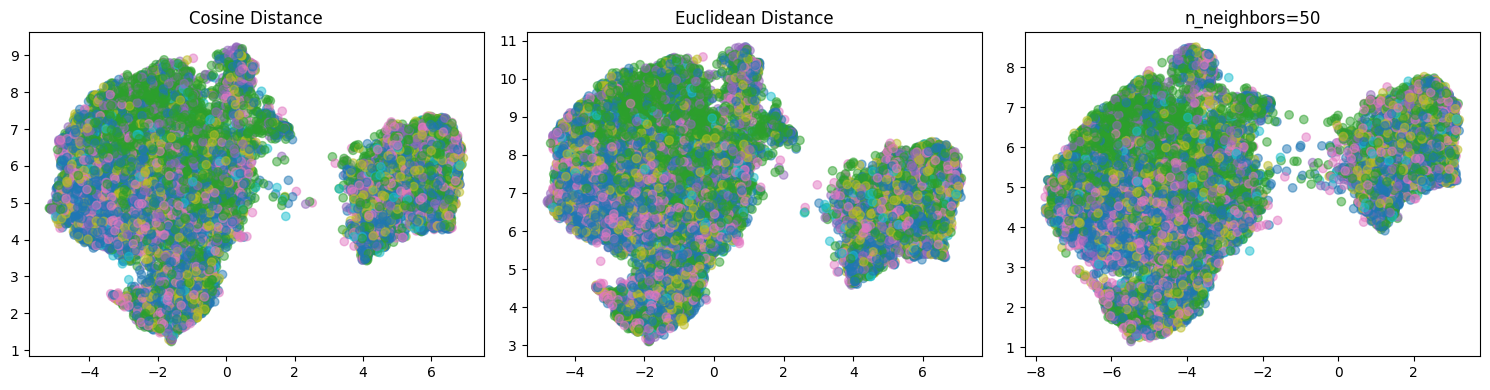

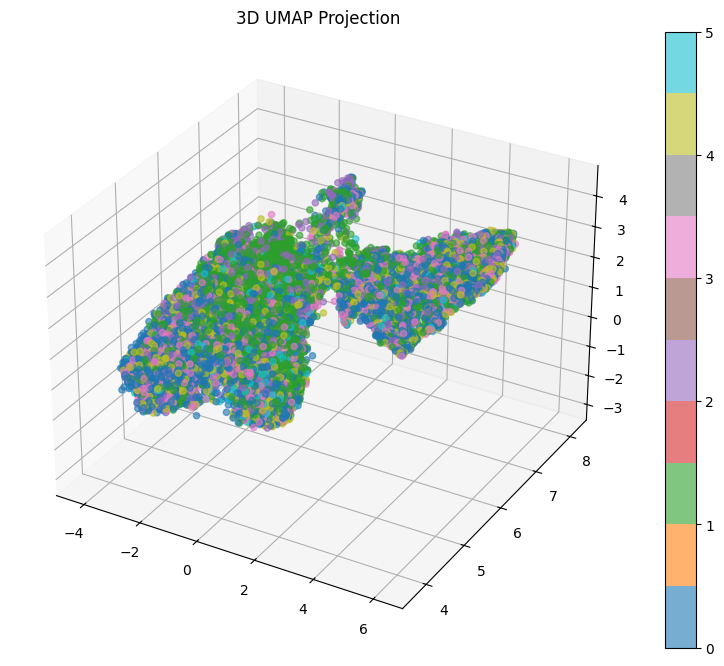

In [19]:
from umap import UMAP

# Original: 2D with cosine
mapper_2d_cosine = UMAP(n_components=2, metric="cosine", random_state=42).fit(X_scaled)

# Experiment 1: 3D with cosine
mapper_3d_cosine = UMAP(n_components=3, metric="cosine", random_state=42).fit(X_scaled)

# Experiment 2: 2D with euclidean
mapper_2d_euclidean = UMAP(n_components=2, metric="euclidean", random_state=42).fit(X_scaled)

# Experiment 3: Different n_neighbors
mapper_2d_neighbors = UMAP(n_components=2, metric="cosine", n_neighbors=50, random_state=42).fit(X_scaled)

# Visualize 2D comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cosine
df_cosine = pd.DataFrame(mapper_2d_cosine.embedding_, columns=["X", "Y"])
df_cosine["label"] = y_train
axes[0].scatter(df_cosine["X"], df_cosine["Y"], c=df_cosine["label"], cmap='tab10', alpha=0.5)
axes[0].set_title("Cosine Distance")

# Euclidean
df_euclidean = pd.DataFrame(mapper_2d_euclidean.embedding_, columns=["X", "Y"])
df_euclidean["label"] = y_train
axes[1].scatter(df_euclidean["X"], df_euclidean["Y"], c=df_euclidean["label"], cmap='tab10', alpha=0.5)
axes[1].set_title("Euclidean Distance")

# Different neighbors
df_neighbors = pd.DataFrame(mapper_2d_neighbors.embedding_, columns=["X", "Y"])
df_neighbors["label"] = y_train
axes[2].scatter(df_neighbors["X"], df_neighbors["Y"], c=df_neighbors["label"], cmap='tab10', alpha=0.5)
axes[2].set_title("n_neighbors=50")

plt.tight_layout()
plt.show()

# For 3D visualization
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
df_3d = pd.DataFrame(mapper_3d_cosine.embedding_, columns=["X", "Y", "Z"])
df_3d["label"] = y_train
scatter = ax.scatter(df_3d["X"], df_3d["Y"], df_3d["Z"], c=df_3d["label"], cmap='tab10', alpha=0.6)
ax.set_title("3D UMAP Projection")
plt.colorbar(scatter)
plt.show()

The UMAP projection shows that sentences with the same emotion tend to form clusters, although some overlap remains between similar emotions. This overlap explains part of the classification errors observed.

## Exercise 4

In [21]:
from transformers import TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6
)

training_args = TrainingArguments(
    output_dir="distilbert-emotion",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    eval_strategy="epoch",
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2753709623.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Exercise 5

In [22]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

text = "I am so happy today!"
classifier(text)

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.15561345219612122},
  {'label': 'LABEL_1', 'score': 0.16147381067276},
  {'label': 'LABEL_2', 'score': 0.1557212918996811},
  {'label': 'LABEL_3', 'score': 0.17764486372470856},
  {'label': 'LABEL_4', 'score': 0.18001757562160492},
  {'label': 'LABEL_5', 'score': 0.16952894628047943}]]

Overall, fine-tuning the transformer improves classification performance compared to using frozen embeddings. The validation metrics show higher accuracy and F1-score, indicating better task-specific representations.

## Exercise 6

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       550
         joy       0.33      0.00      0.00       704
        love       0.00      0.00      0.00       178
       anger       0.13      0.80      0.22       275
        fear       0.07      0.09      0.08       212
    surprise       0.00      0.00      0.00        81

    accuracy                           0.12      2000
   macro avg       0.09      0.15      0.05      2000
weighted avg       0.14      0.12      0.04      2000



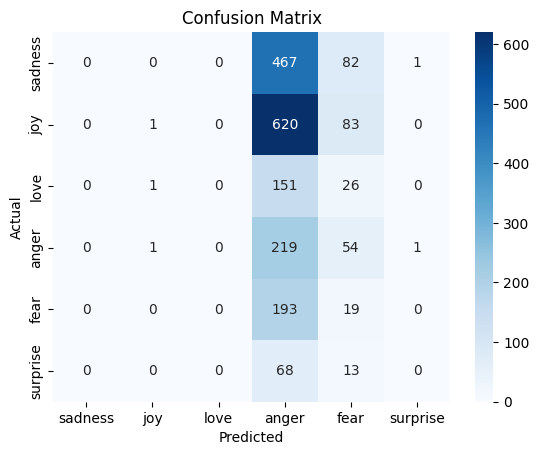

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_preds = np.argmax(trainer.predict(emotions_encoded["validation"]).predictions, axis=1)
y_true = np.array(emotions_encoded["validation"]["label"])

# Classification Report
print(classification_report(y_true, y_preds, target_names=emotions["train"].features["label"].names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions["train"].features["label"].names, yticklabels=emotions["train"].features["label"].names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix shows that most errors occur between semantically close emotions such as joy and love. Overall accuracy and weighted F1-score confirm stable performance despite class imbalance.